In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
import os
import sys
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import gym

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# tf.config.list_physical_devices(device_type='GPU')

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

tf.random.set_seed(seed)
# tensorflow 如何设置在GPU上能够复现结果还不太清楚怎么弄

In [3]:
path = os.path.abspath('..')
if path not in sys.path:
    sys.path.append(path)

In [4]:
from configs import Config
from replay_memories import ExperienceReplayMemory
from networks_tensorflow import MLP_tensorflow
from agents_tensorflow import DQNAgentTensorflow

# Training Loop

- DQNAgent里的`double`参数要修改一下

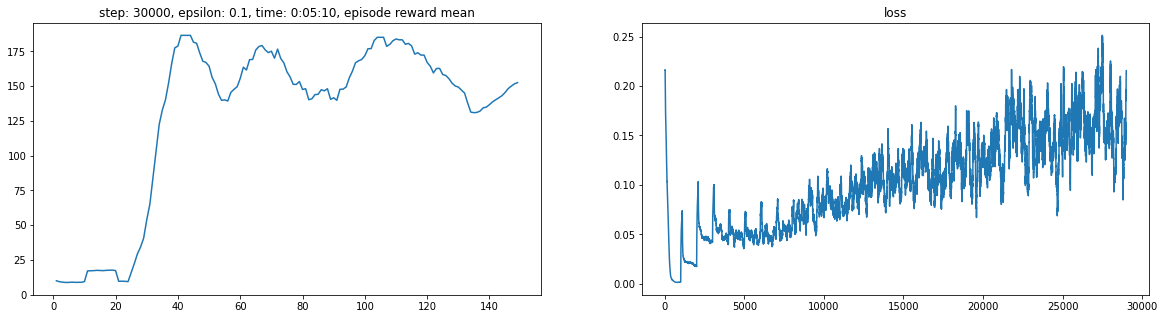

step: 31000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:05:20
episode reward mean: 151.8, epsisode reward max: 160.0, episode length mean: 151.8, episode length max: 160, loss: 0.5204547643661499
step: 32000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:05:31
episode reward mean: 164.8, epsisode reward max: 172.0, episode length mean: 164.8, episode length max: 172, loss: 0.11184040457010269
step: 33000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:05:41
episode reward mean: 158.8, epsisode reward max: 167.0, episode length mean: 158.8, episode length max: 167, loss: 0.2863020896911621
step: 34000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:05:53
episode reward mean: 163.8, epsisode reward max: 168.0, episode length mean: 163.8, episode length max: 168, loss: 0.1175687313079834
step: 35000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:06:05
episode reward mean: 186.6, epsisode reward max: 194.0, episode length mean: 186.6, episode length max: 194, loss: 0.337799

In [7]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgentTensorflow(env_name=name, network=MLP_tensorflow, double=True, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, lr: {}, time: {}'.format(step, epsilon, dqn_agent.optimizer.lr(step).numpy(), timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
    
#         print('==========================================')
#         print([(tf.reduce_max(param).numpy(), tf.reduce_min(param).numpy(), tf.reduce_max(grad).numpy(), tf.reduce_min(grad).numpy()) for (grad, param) in zip(dqn_agent.grads, dqn_agent.model.trainable_variables)])
#         print('==========================================')
      
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-20:]).mean() > 195:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
        if mean_returns > 195: 
            print('Solved!')
            break 
        
# dqn_agent.render(env_eval)

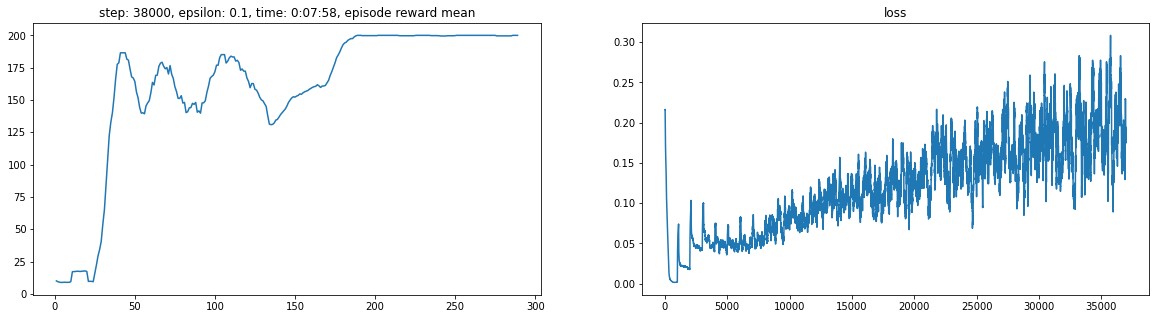

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
plt.subplot(122)
plt.title('loss')
plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
plt.show()

In [9]:
dqn_agent.model.save_weights('./doubledqn_cartpole.ckpt')

In [11]:
dqn_agent.render(env_eval)

## n-steps replay buffer

- DQNAgent里的`n_steps`参数要修改一下
- 另外在收集数据的时候，使用self.n_steps_replay()，而不是self.memory.add()

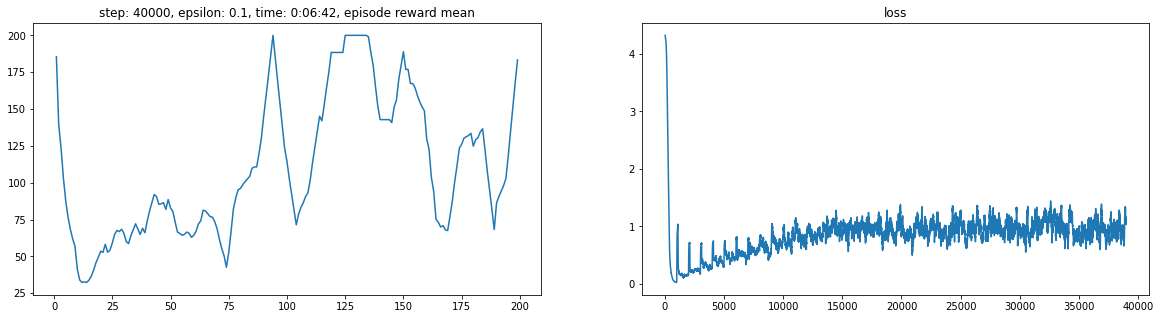

step: 41000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:06:53
episode reward mean: 169.4, epsisode reward max: 182.0, episode length mean: 169.4, episode length max: 182, loss: 0.799030601978302
step: 42000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:07:04
episode reward mean: 189.2, epsisode reward max: 200.0, episode length mean: 189.2, episode length max: 200, loss: 1.0640664100646973
step: 43000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:07:15
episode reward mean: 132.8, epsisode reward max: 200.0, episode length mean: 132.8, episode length max: 200, loss: 0.5888279676437378
step: 44000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:07:25
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.8399209976196289
step: 45000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:07:35
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 1.62953698

In [13]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgentTensorflow(env_name=name, network=MLP_tensorflow, double=True, n_steps=5, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
#     dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    dqn_agent.n_steps_replay((pre_obs, action, reward, obs, done))
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, lr: {}, time: {}'.format(step, epsilon, dqn_agent.optimizer.lr(step).numpy(), timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
    
#         print('==========================================')
#         print([(tf.reduce_max(param).numpy(), tf.reduce_min(param).numpy(), tf.reduce_max(grad).numpy(), tf.reduce_min(grad).numpy()) for (grad, param) in zip(dqn_agent.grads, dqn_agent.model.trainable_variables)])
#         print('==========================================')
      
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-20:]).mean() > 195:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
        if mean_returns > 195: 
            print('Solved!')
            break 
        
# dqn_agent.render(env_eval)

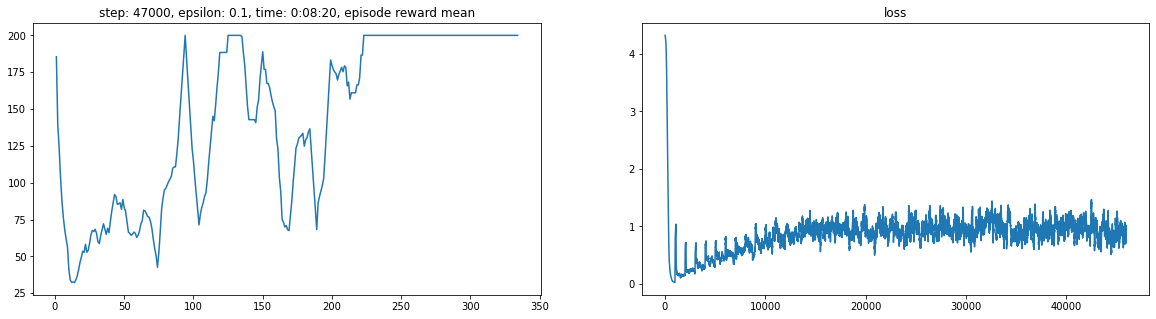

In [14]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
plt.subplot(122)
plt.title('loss')
plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
plt.show()